In [1]:
import os
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

# better display of review text in dataframes
pd.set_option('display.max_colwidth', -1) 

RANDOM_SEED = 49
random.seed(RANDOM_SEED) 

# Load pickle files

In [2]:
PICKLE_DIR = 'pickle'

allocine_df = pd.DataFrame()

#TODO: add series ?
# -> 150001 and on !
for filename in os.listdir(PICKLE_DIR):
    if filename.endswith(".pickle"):        
        path = os.path.join(PICKLE_DIR, filename)
        print("Reading file: " + path)
        df = pd.read_pickle(path)
        allocine_df = allocine_df.append(df, ignore_index=True)

print()
print("Loaded {} reviews !".format(len(allocine_df)))

Reading file: pickle/allocine_15001_25000.pickle
Reading file: pickle/allocine_8001_15000.pickle
Reading file: pickle/allocine_1_1000.pickle
Reading file: pickle/allocine_1001_5000.pickle
Reading file: pickle/allocine_5001_8000.pickle

Loaded 279591 reviews !


# Explore data

In [3]:
allocine_df.sample(5, random_state=RANDOM_SEED)

,film-id,rating,review,date,helpful,unhelpful
185909,1603,5.0,Le grand classique par excellence. Toutes les critiques au sujet du film se ressemble car l'effet est presque le même sur tout le monde . Un scénario qui évolue pas à pas mais tout de même de manière assez rapide pour un final d'anthologie. Le noir et blanc apporte par contre un véritable charme supplémentaire au film. Hitchcock avait vraiment réussi un grand coup avec film.,2013-05-09,0,0
51794,22779,5.0,"Ce film tiré du roman de Stephen King est une merveille en soi. Le film repose sur un bloc particulier dans une prison : celui du couloir de la mort. L'histoire se passe dans les 1930, date à laquelle les exécutions étaient réalisés sous la chaise électrique. Tout va basculer dans la vie du chef de bloc incarné par Tom Hanks lorsqu'un prisonnier arrivera doté d'étranges pouvoirs... Il ne faut pas en dire trop car le suspense faut son pesant d'or et les larmes couleront durant le film devant tant de beauté et de tristesse.\nBref : Nous sommes tous promis à la mort, tous sans exceptions. Mais pour certains parfois la ligne verte semble bien longue.",2019-04-09,3,0
134886,14928,2.5,"Franchement déçu... Moi qui m'attendais à quelque chose de sensationnel, depuis le temps que j'en entendais parler! Le film peine vraiment à démarrer (le fait-il d'ailleurs?) et le rythme est sommes toutes très lent. Cette histoire vraie(ment fictive) est sinon interessante du point de vue du traitement légendaire des Coen : repères bousculés, refus des caricatures des bas étage, ton volontairement abrupt et surprenant... Par exemple, j'adore toutes les scènes de William H. Macy (les appels du gars pour les n° de plaques d'immatriculation, les interrogatoires de la policière). Pendant qu'on y est : superbe Frances McDormand qui ne demande qu'à retrouver tout les soirs son mari dessinateur de timbre (si g bien compris). Que dire de Steve Buscemi et peter Stormare (merveilleuse loque blonde obnubilé par de séries TV médiocres et un peu avare de conversation) sinon qu'ils donnent un aperçu jouissif de leurs prochains faits d'armes dans le polar. La musique de Carter Burwell est transcendante, j'en convient mais je trouve que le film ne la mérite presque pas; et elle intervient beaucoup trop tôt dans le film (dès le géénrique quoi). Plus de point positifs que négatifs mais sa réputation me faisait espérer une ouevre au-delà de la simple évocation tragi-comique d'un fait divers dont les seuls éléments valables semble la violence et l'absurdité. C'est bien mais ça ne suffit pas.",2008-01-31,0,0
200255,2124,2.5,"Après une présentation fétichiste des personnages que Jean-Pierre Jeunet empruntera pour son «Fabuleux destin d’Amélie Poulain», Alain Resnais entame «Mon oncle d’Amérique» (France, 1980). La présentation rapide et fugace des trois personnages principaux laisse place à l’approfondissement de leurs vies, aux fruits de leurs choix et à l’implacable déterminisme dont l’individu est victime. Resnais est l’un des plus grand formaliste français, pour le meilleur («Muriel ou le temps d’un retour», «Cœurs», «L’amour à mort») ou pour le moins bon en l’occurrence. La genèse du film explique peut-être son insipidité. L’initiative de l’œuvre ne vient pas de Resnais mais d’Henri Laborit, chercheur spécialisé sur les comportements humains. C’est ainsi que s’enfuit sous nos yeux la poésie de «Je t’aime, je t’aime», la politique d’«Hiroshima, mon amour» et même le délire de «Providence». En ponctuant son film d’interventions scientifiques, de commentaires explicatifs sur les rouages des modes de comportements humains, Resnais et Laborit assèchent le film de toute poésie, de toute grâce lyrique. La seule présence poétique se restreint à l’analogie triviale faite entre chacun des personnages et leurs idoles cinématographiques. Ainsi les personnages de Nicole Garcia, Gérard Depardieu et Roger Pierre sont respectivement représentés par Jean Marais, Jean Gabin et Danielle Darrieux. Le film ne demeure pas san

In [4]:
allocine_df.head(2)

,film-id,rating,review,date,helpful,unhelpful
0,15002,4.0,"Tueurs de vampires, les vampires nous appellent. Tels sont les mots prononcés par George Clooney lorsqu'il charge les suceurs de sang, vers la fin du film. Et oui, cette phrase en est l'exemple, Une nuit en enfer bénéficie de dialogues excellents et de punchlines devenues cultes. On y suivra la descente aux enfers de deux voleurs et de leurs trois otages qui, attaqués par des vampires, devront survivre coûte que coûte dans ce qui semblait être le paradis des motards. Le paradis, oui, mais le jour, pas la nuit. On passe le plus clair de son temps à sourire devant les dialogues Tarantiniesques et les situations made in Rodriguez , alors que le gore si cher à son réalisateur est omniprésent. Oui, c'est violent, même ultra-violent, mais le film est tellement barge et ne se prend tellement pas au sérieux que tout ces artifices ne sont pas gênants au bon déroulement, non, ils rentrent tout à fait dans l'ambiance générale et trouvent leur place parmi les vampires caricaturaux et les personnages très bien développés. Les deux compères utilisent les stéréotypes et autres lieux communs du genre fantastique et en particulier du vampirisme pour les modifier à leur sauce et ainsi donner leur propre version du mythe gothique. Pendant la première heure du métrage, on se dit de bout en bout que l'on va assister à une nouvelle course poursuite entre gangsters-policiers. Après la première heure, un twist inattendu et surprenant vient bouleverser nos attentes et autres pensées. Et oui, car ils aiment jouer avec nos sentiments et faire passer leur oeuvre pour ce qu'elle n'est pas, c'est à dire un banal film d'action. Derrière le résultat final se trouve bien plus qu'une simple série b. Derrière le résultat final se trouve un film de qualité, personnel et qui jouit d'une aura unique, de par son côté série b évidemment volontaire et son jeu d'acteurs tout à fait honorable.",2014-07-19,17,3
1,15002,3.0,"Un film déjanté en deux actes, dans lequel Quentin Tarantino et George Clooney forment un duo époustouflant. La première partie de la réalisation est excellente, tout bonnement hilarante, on y retrouve la patte de Tarantino avec des dialogues et des personnages complètement surréalistes. Cependant, le reste du film bascule ensuite, de manière soudaine, dans l’univers fantastique, farfelu, et surtout complètement différent de Rodriguez. On est alors nettement en dessous du début du film, et la réalisation perd sa crédibilité, on passe du road-movie au film horrifique ! Dommage !",2014-01-19,17,3


Pickle files are not loaded in order.
We sort the dataframe by film id for convenience

In [5]:
# Pickle files are not loaded in order
# We sort the dataframe by film id
# TODO => don't do that. Sort path at the loading part so we don't have to do this
allocine_df = allocine_df.sort_values("film-id")
allocine_df = allocine_df.reset_index(drop=True)

In [6]:
allocine_df.head(2)

,film-id,rating,review,date,helpful,unhelpful
0,1,5.0,"Ah! Quel plaisir de revoir ce grand fou de Jack Nicholson dans un rôle crapuleux, lui qui avait terrorisé le monde entier dans sa prestation dans ""Shining"" de Stanley Kubrick! Le film est le remake d'un film des années 1940 mais il n'a pas à rougir devant l'original car le successeur le dépasse dans tous les domaines! Le scénario est très bien construit, il est très riche, très dense et attire les yeux du spectateur un peu voyeur devant les scènes sulfureuses et parfois très violentes réalisées de main de maître par Bob Rafelson. Le film respecte les codes du film noir dans la mesure où trois protagonistes sont liés à savoir le mari, la femme et son amant. Devant un tel spectacle, difficile de rester insensible devant cette débauche d'énergie délivrée par Jack Nicholson et Jessica Lange qui impressionnent par leurs talents d'acteurs. Le film relate un crime, celui de tuer le mari. Le long-métrage regorge de rebondissements et nous sommes exposés à suivre les opérations des deux amants qui veulent réaliser le crime parfait. Le réalisateur montre les policiers comme des traqueurs et des chercheurs de troubles pour inculper les deux amants. L'intérêt dans tout cela, c'est de montrer comment une femme soumise dans les années 1940 est malheureuse et cherche un homme qui saurait la sortir de son quotidien répétitif et ennuyeux à cause duquel elle éprouve une terrible névrose. D'un autre coté, voici l'exemple d'un opportuniste déjà emprisonné qui voit se profiler un cas intéressant: un mari qui passe son temps à se saouler et à donner des tapes sur les fesses de sa femme et qui possède un restaurant assez bien coté. Il endort sa méfiance en se faisant embaucher comme simple mécanicien pour mieux séduise sa femme lorsqu'il s'absente. Les rapports entre la femme et son amant sont complexes: ils se désirent, ils s'aiment mais ils ont peur de commettre le crime. Au final, un film qui se veut sulfureux, intelligent, immoral avant la dernière scène du film vraiment épouvantable.",2010-03-14,3,4
1,1,4.0,"Jack Nicholson et Jessica Lange réinventent avec panache, brio, violence et sexualité le couple des amants diaboliques dans ce remake tout aussi culte que l'original.",2011-10-12,1,1


## Negative reviews

We consider a review is negative when its associating rating is less than or equal to 2.0, which includes 4 categories: 0.5, 1.0, 1.5 and 2.0

In [7]:
negative_reviews = allocine_df[allocine_df['rating'] <= 2.0]
negative_reviews.sample(3, random_state=RANDOM_SEED)

,film-id,rating,review,date,helpful,unhelpful
113994,5453,2.0,Un film sombre qui nous entraîne laborieusement dans l'univers opaque des services secrets.,2011-08-08,0,2
171815,10555,2.0,"Plus de 13 ans après sa sortie ce film d'action reste efficace et s'avère un bon divertissement. La version Director's cut disponible en dvd vaut vraiment le détour, pour bons nombres de scènes et dialogues gratuits et inutiles! Rires garantis. Un film au premier abord très américain, bourré d'honneur, paternaliste, mais où tout est assumé ; ce qui lui donne presque aujourd'hui les allures d'un joyeux nanard! malgré quelques incohérences de montage, le film a tout de même une réalisation très active et une superbe photographie qui aujourd'hui encore n'a pas pris une ride.",2011-03-12,0,0
116023,5757,2.0,"Les acteurs sont très bons, mais le film manque cruellement de rythme.",2015-06-12,1,1


## Positive reviews

We consider a review is positive when its associating rating is greater than or equal to to 4.0, which includes 3 categories: 4.0, 4.5 and 5.0

In [8]:
positive_reviews = allocine_df[allocine_df['rating'] >= 4.0]
positive_reviews.sample(3, random_state=RANDOM_SEED)

,film-id,rating,review,date,helpful,unhelpful
234762,17218,5.0,Dieu que je l'aime ce film! Un pur western-vampirique avec un James Woods fabuleux! Aux répliques tordantes et cultes et pas mal de scènes surprenantes (du moins pas mal de tension lors du premier visionnage) avec quelques séquences gores vraiment bien réalisés. Le tout accompagné d'une musique made in Carpenter à la sauce western proche d'un Ennio Morricone! Grandiose ce Vampires!,2007-11-08,0,0
104555,4966,4.5,"L'un des premier film sur Batman, excellent : Alors qu’il n’était qu’un enfant, Bruce Wayne vécu la mort de ses parents en direct. Ils furent tués par un voleur. Après ces évènements, il décida de combattre le crime toute sa vie grâce à ses talents en arts martiaux et à sa fortune personnelle. Il crée un double de lui-même nommé Batman. Le jour, il est le playboy milliardaire Bruce Wayne et la nuit il est Batman, justicier impitoyable envers les criminels. La ville dans laquelle il vit, Gotham City, est en proie à la délinquance, au crime et est en partie contrôlée par la pègre de Carl Grissom. Mais le pire reste à venir : un nouvel ennemi, le Joker, est près à faire mourir de rire les citoyens de la ville... C'est vraiment un très bon film de Batman : les acteurs sont excellents, les combats également, les effets et la BO, sublime. Bref, un superbe hommage au justicier masqué !",2018-07-09,2,0
83546,3326,5.0,cet un de ses film qui a fais ma jeunesse le conte de fée par exellence drole est féerique les acteurs sont exellent,2010-01-13,1,1


# TODO

In [9]:
sns.set(style="whitegrid")

## Rating counts

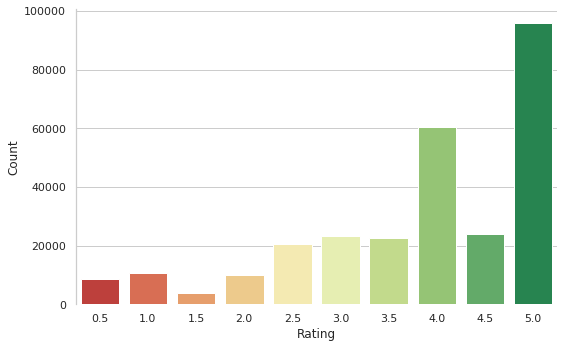

In [10]:
plt.figure(figsize=(8,5))

goodbad_palette = sns.color_palette("RdYlGn_r", n_colors=10)
goodbad_palette.reverse()

ax = sns.countplot(data=allocine_df, x='rating', palette=goodbad_palette)
ax.set(xlabel='Rating', ylabel='Count')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/rating_counts.png', dpi=400)

## Polarity

In [11]:
def find_polarity(row):
    if row['rating'] <= 2.0:
        return -1
    elif row['rating'] >= 4.0:
        return 1
    else:
        return 0

allocine_df['polarity'] = allocine_df.apply(lambda row : find_polarity(row), axis=1) 

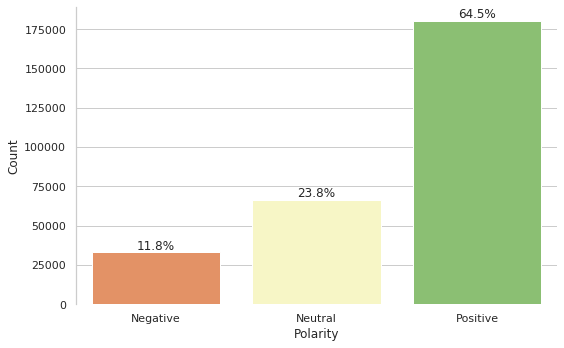

In [12]:
plt.figure(figsize=(8,5))

goodbad_palette = sns.color_palette("RdYlGn_r", n_colors=3)
goodbad_palette.reverse()

ax = sns.countplot(data=allocine_df, x='polarity', palette=goodbad_palette)
ax.set(xlabel='Polarity', ylabel='Count')
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])

# Frenquencies
ncount = len(allocine_df)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/polarity_frequency.png', dpi=400)

## Reviews per year

In [13]:
allocine_df['date'] = pd.to_datetime(allocine_df['date'])
reviews_per_year = allocine_df.groupby(allocine_df['date'].dt.year).size()

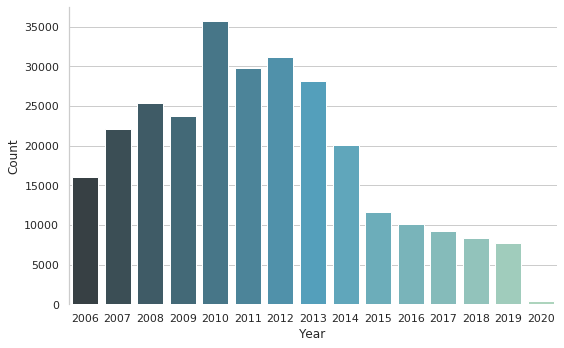

In [14]:
plt.figure(figsize=(8,5))
ax = sns.barplot(reviews_per_year.index, reviews_per_year.values, palette="GnBu_d")
ax.set(xlabel='Year', ylabel='Count')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/reviews_per_year.png', dpi=400)

## Reviews length

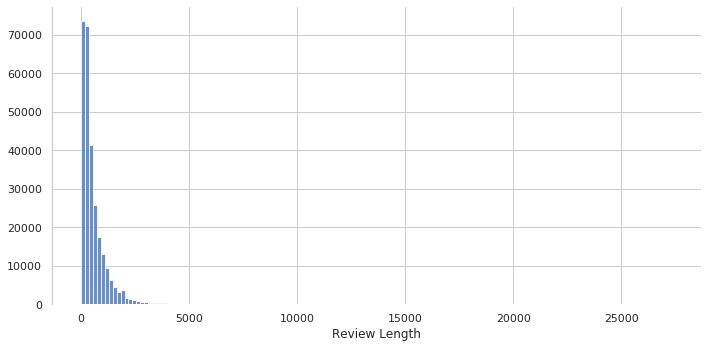

In [15]:
reviews_length = allocine_df['review'].str.len()

plt.figure(figsize=(10,5))
ax = sns.distplot(reviews_length, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Review Length')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/reviews_length.png', dpi=400)

In [16]:
THRESHOLD = 4000
short_reviews = allocine_df[allocine_df['review'].str.len() <= THRESHOLD]
long_reviews =  allocine_df[allocine_df['review'].str.len() > THRESHOLD]

print("{} reviews with LEN > {} ({:.2f} % of total data)".format(
    len(long_reviews),
    THRESHOLD,
    100 * len(long_reviews) / len(allocine_df)
))

1292 reviews with LEN > 4000 (0.46 % of total data)


Example of a long review

In [17]:
long_reviews.head(1)

film-id  rating  \
118  8        2.0      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

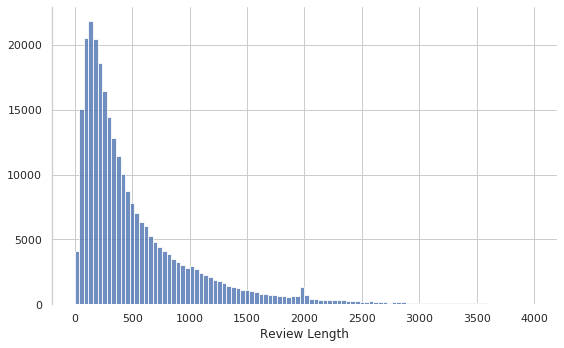

In [18]:
short_reviews_length = short_reviews['review'].str.len()

plt.figure(figsize=(8,5))
ax = sns.distplot(short_reviews_length, bins=100, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Review Length')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/short_reviews_length.png', dpi=400)

In [ ]:
# TODO: other analysis ?
# Histograms of reviews lengths for each rating (negative reviews are shorter ?)

In [ ]:
# Num reviews per film ? => why are we limiting to 30 reviews per film ?

# Build dataset

In [19]:
dataset_df = allocine_df.copy()
initial_len = len(dataset_df)
print("Length: {}".format(initial_len))

Length: 279591


## Remove data we don't need 

In [20]:
def loss_percentage(df, previous_length):
    new_length = len(df)
    percentage = 100*(1-(new_length/previous_length))    
    return new_length, percentage  

In [21]:
# 1. Drop columns we don't need
dataset_df = dataset_df.drop(columns=['rating', 'date', 'helpful', 'unhelpful'])

# 2. Drop rows we don't need (neutral polarity)
dataset_df = dataset_df[dataset_df['polarity'] != 0]
length, percentage = loss_percentage(dataset_df, initial_len)
print("Length: {} (-{:.1f} %)".format(length, percentage))

# 3. Remove long reviews
LENGTH_THRESH = 4000
dataset_df = dataset_df[dataset_df['review'].str.len() <= LENGTH_THRESH]
length, percentage = loss_percentage(dataset_df, length)
print("Length: {} (-{:.1f} %)".format(length, percentage))

# 4. Limit number of reviews per film
MAX_REVIEWS_PER_FILM = 30
grouped = dataset_df.groupby('film-id')
for ids in grouped.groups.values():
    num_reviews = len(ids)    
    if num_reviews > MAX_REVIEWS_PER_FILM:
        sampling_size = num_reviews - MAX_REVIEWS_PER_FILM
        ids_to_drop = random.sample(list(ids), sampling_size)
        dataset_df = dataset_df.drop(ids_to_drop)
        
length, percentage = loss_percentage(dataset_df, length)
print("Length: {} (-{:.1f} %)".format(length, percentage))

# Total loss
length, percentage = loss_percentage(dataset_df, initial_len)
print("Total loss: (-{:.1f} %)".format(percentage))

Length: 213151 (-23.8 %)
Length: 212136 (-0.5 %)
Length: 53468 (-74.8 %)
Total loss: (-80.9 %)


In [22]:
dataset_df.groupby('polarity').size()

polarity
-1    13599
 1    39869
dtype: int64

## Clean review text

In [23]:
import re

def clean_text(text):
    text = text.replace('\xa0', ' ')
    text = text.replace('\x92', "'")
    
    # Substituting multiple spaces with single space
    # Also remove '\n' and '\r' occurences
    text= re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text
 
dataset_df['review'] = dataset_df['review'].apply(clean_text)

In [24]:
dataset_df.sample(5, random_state=RANDOM_SEED)

,film-id,review,polarity
139897,7570,"Ce deuxième opus burtonien des aventures de l'homme chauve-souris est plus réussi encore que la version de 1989. La raison ? L'ambiance gothico-violente de la ville de Gotham City qui fait mouche, et surtout les méchants, absolument géniaux. Le Pingouin, alias Danny DeVito est époustouflant dans son rôle de monstre des égouts qui nécessitait deux heures de maquillage chaque jour ; Catwoman alias Michelle Pfeiffer est plus sexy que jamais dans sa tenue de cuir noir sortie tout droit d'un club SM ; Christopher Walken alias Max Shreck est délicieux dans la peau d'un entrepreneur véreux ne reculant devant rien pour parvenir à ses fins. Un délice.",1
203400,13247,Le début de la fin pour Kevin Costner habitué jusque là aux succès. Waterworld frise le waternanarland tout au long du film avec un scénario très limité et pompé en partie sur du Mad max sans la qualité technique. Du mauvais blockbuster pour engrenger au box office et rien de plus.,-1
21916,379,"Bizarre ce western de John Sturges, ce n'est pas forcément nul ou lent (au contraire) mais ce n'est pas forcément captivant, il n'y a pas vraiment de prise de folie, que ce soit au niveau du scénario ou de la mise en scène, c'est très classique. Et c'est même un peu trop prévisible. De plus on reste vraiment sur notre faim, notamment à propos du duel Eastwood/Duvall. Il n'y a pas vraiment d'émotions qui se dégagent du film, c'est assez froid. Dommage car Clint Eastwood est parfait dans un rôle qu'il connait bien. Néanmoins, le réalisateur ne prend pas partis, et ne fait l'éloge ni des Américains, ni des Mexicains. Bref rien de vraiment honteux, on a vu pire, mais rien de mémorable et une déception vu le nom du réalisateur (à qui on doit les sept mercenaires ou encore la grande évasion) et du casting pourtant alléchant.",-1
214965,14675,"Dernier et moins bon (euphémisme) film de la période allemande de Douglas Sirk : on le sent sur le départ et perturbé par les contraintes des autorités hitlériennes. Kitchissime, incohérent, sans queue ni tête : mélange de romance over-boostée à la chantilly dégoulinante et d’aventures à la Tintin chez les Picaros survoltées, où débarquent des scientifiques venus combattre une fièvre mortelle qui découvrent le virus en une nuit dans leur chambrette d’hôtel. Tout cela sur fond d’orchestres mariachis, de romances de Noel allemandes, d’airs de corridas pour la musique et de déguisements d’opérettes hallucinants, d’accroches cœur en série et de lunettes de soleil à géométrie variable pour les costumes. A voir au quatrième degré.",-1
30092,675,"Ce film aurait du changer de titre, ""L'ennui"" lui aurait fort bien convenu. Quand on n'a pas grand chose à dire, il est inutile de rallonger les scènes à foison, d'ajouter du silence et de l'inaction. Tout ce propos aurait très bien pu tenir dans un court métrage de 15 minutes, mais il n'est même pas certain qu'il aurait été bon.",-1


## Balance classes

In [25]:
# The overall distribution of labels is balanced (25k pos and 25k neg).
# We don't have to have train and testset perfectly balanced

balanced_df = dataset_df.copy()

MAX_REVIEWS_PER_POLARITY = 13000
# 4. Limit number of reviews per film
grouped = balanced_df.groupby('polarity')
for ids in grouped.groups.values():
    num_reviews = len(ids)    
    if num_reviews > MAX_REVIEWS_PER_POLARITY:
        sampling_size = num_reviews - MAX_REVIEWS_PER_POLARITY
        ids_to_drop = random.sample(list(ids), sampling_size)
        balanced_df = balanced_df.drop(ids_to_drop)

In [26]:
print(balanced_df.groupby('polarity').size())
balanced_df.head(10)

polarity
-1    13000
 1    13000
dtype: int64


,film-id,review,polarity
0,1,"Ah! Quel plaisir de revoir ce grand fou de Jack Nicholson dans un rôle crapuleux, lui qui avait terrorisé le monde entier dans sa prestation dans ""Shining"" de Stanley Kubrick! Le film est le remake d'un film des années 1940 mais il n'a pas à rougir devant l'original car le successeur le dépasse dans tous les domaines! Le scénario est très bien construit, il est très riche, très dense et attire les yeux du spectateur un peu voyeur devant les scènes sulfureuses et parfois très violentes réalisées de main de maître par Bob Rafelson. Le film respecte les codes du film noir dans la mesure où trois protagonistes sont liés à savoir le mari, la femme et son amant. Devant un tel spectacle, difficile de rester insensible devant cette débauche d'énergie délivrée par Jack Nicholson et Jessica Lange qui impressionnent par leurs talents d'acteurs. Le film relate un crime, celui de tuer le mari. Le long-métrage regorge de rebondissements et nous sommes exposés à suivre les opérations des deux amants qui veulent réaliser le crime parfait. Le réalisateur montre les policiers comme des traqueurs et des chercheurs de troubles pour inculper les deux amants. L'intérêt dans tout cela, c'est de montrer comment une femme soumise dans les années 1940 est malheureuse et cherche un homme qui saurait la sortir de son quotidien répétitif et ennuyeux à cause duquel elle éprouve une terrible névrose. D'un autre coté, voici l'exemple d'un opportuniste déjà emprisonné qui voit se profiler un cas intéressant: un mari qui passe son temps à se saouler et à donner des tapes sur les fesses de sa femme et qui possède un restaurant assez bien coté. Il endort sa méfiance en se faisant embaucher comme simple mécanicien pour mieux séduise sa femme lorsqu'il s'absente. Les rapports entre la femme et son amant sont complexes: ils se désirent, ils s'aiment mais ils ont peur de commettre le crime. Au final, un film qui se veut sulfureux, intelligent, immoral avant la dernière scène du film vraiment épouvantable.",1
11,1,"De la dynamite! Les annèes 80 ont ètè marquèes par un retour au thème et aux personnages du passè! Ce retour au passè peut aussi permettre une vèritable approche de certaines thèmes, jusque là occultès par la censure! C'est ainsi que ""The Postman Always Rings Twice"" de Bob Rafelson peut enfin aller jusqu'au bout des implications du formidable roman de James Crain et donner à la sexualitè la place qui lui revient enfin dans l'histoire. ""Body Heat"" de Kasdan où, comme cette quatrième version de ""The Postman Always Rings Twice"" après Pierre Chenal, Luchino Visconti et Tay Garnett (ainsi que la plupart des romans de Cain), c'est la femme qui mène le jeu! Et elle mène le jeu avec ses armes! Dèfinitivement affranchie sexuellement, elle joue de son corps en toute libertè et sans ressentir la moindre culpabilitè! L'imposant Jack Nicholson et la sublime Jessica Lange forment un couple extraordinaire et leurs èbats sulfureux dans la farine ont fait date dans l'histoire du cinèma! Une scène de cul grand cru avec deux excellents comèdiens qui se sont totalement investis dans la conception de cette oeuvre intense et sensuelle, prototype même du film noir contemporain de demain! Tous les ingrèdients sont rèunis pour un duo de lègende à jamais dans nos mèmoires! Et dire que certaines critiques ont jugè ce remake racoleur et superficiel! Comme quoi, tous les goûts cinèphiliques sont dans la nature même si selon moi la version en noir & blanc de Garnett est un cran au-dessus à la version colorisèe de Rafelson...",1
13,1,"Je l’ai déjà dit plusieurs fois sur ce site, mais je le redis encore une fois: Jack Nicholson, j’adore, tout simplement. C’est comme ça depuis je ne sais combien de temps, et ça ne changera jamais, soyez-en sûrs. Et c’est justement pour ça, que c’est avec vraiment beaucoup de peine que je n’ai collé qu’une petite étoile à ce film. Je plaisante pas, ça m’a vraiment pas fait plaisir, mais, pour le coup, j’ai pas eu d’aut

In [119]:
# split train / test
# While True
# 1. random in train_set ids => find corresponding row
# 2. add all rows with same film id test_set
# 3. is test_proportion reached ? Yes: STOP, No continue

# => verify this split preserve the balanced distribution of classes